In [1]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import pytensor.tensor as tt

rng = np.random.default_rng(1331)

In [2]:
pxi_df = pd.read_csv(r"data/pxi_results.csv")

pxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   participant_id  163 non-null    object 
 1   game_name       163 non-null    object 
 2   trial           163 non-null    float64
 3   mode            163 non-null    float64
 4   difficulty      163 non-null    float64
 5   pxi_AA          162 non-null    object 
 6   pxi_CH          163 non-null    object 
 7   pxi_EC          163 non-null    object 
 8   pxi_GR          163 non-null    object 
 9   pxi_PF          163 non-null    object 
 10  pxi_AUT         162 non-null    object 
 11  pxi_CUR         163 non-null    object 
 12  pxi_IMM         162 non-null    object 
 13  pxi_MAS         162 non-null    object 
 14  pxi_MEA         163 non-null    object 
 15  pxi_ENJ         163 non-null    object 
 16  STIMES          163 non-null    float64
 17  TIMES           163 non-null    flo

In [3]:
logs_df = pd.read_csv(r"data/atari_logs.csv").drop("Unnamed: 0", axis=1)

logs_df.head()

,participant_id,game_name,trial,mode,difficulty,frame,action,ram_0,ram_1,ram_2,...,ram_118,ram_119,ram_120,ram_121,ram_122,ram_123,ram_124,ram_125,ram_126,ram_127
0,P004,WordZapper-v5,1,2,3,0,0,182,253,113,...,0,0,0,0,0,0,163,25,190,245
1,P004,WordZapper-v5,1,2,3,1,0,182,253,113,...,0,0,0,0,0,0,163,25,190,245
2,P004,WordZapper-v5,1,2,3,2,0,182,253,113,...,0,0,0,0,0,0,163,25,190,245
3,P004,WordZapper-v5,1,2,3,3,0,182,253,113,...,0,0,0,0,0,0,163,25,190,245
4,P004,WordZapper-v5,1,2,3,4,0,182,253,113,...,0,0,0,0,0,0,163,25,190,245


# Boxing

In [4]:
pxi_df_box = pxi_df[pxi_df["game_name"] == "Boxing"].drop(columns="game_name")

final_frames = logs_df[logs_df["game_name"]=="Boxing-v5"].groupby(["participant_id", "trial"])["frame"].idxmax()
grouped_box_df = logs_df.iloc[list(final_frames.values)]

box_score = grouped_box_df[["participant_id", "trial", "ram_18", "ram_19"]]
box_final = pd.merge(pxi_df_box, box_score, left_on=("participant_id", "trial"), right_on=("participant_id", "trial")).dropna()
box_final.head()


,participant_id,trial,mode,difficulty,pxi_AA,pxi_CH,pxi_EC,pxi_GR,pxi_PF,pxi_AUT,pxi_CUR,pxi_IMM,pxi_MAS,pxi_MEA,pxi_ENJ,STIMES,TIMES,ram_18,ram_19
0,P009,3.0,0.0,0.0,Agree,Strongly Agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,1.746089e+12,1.746090e+12,119,72
2,P015,3.0,0.0,0.0,Neutral,Agree,Agree,Strongly Agree,Slightly agree,slightly disagree,Neutral,Strongly Agree,slightly disagree,slightly disagree,Neutral,1.746528e+12,1.746528e+12,32,56
3,P011,3.0,0.0,3.0,Agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Slightly agree,Agree,Strongly Agree,Agree,Strongly Agree,Strongly Agree,1.746111e+12,1.746111e+12,89,40
4,P003,2.0,0.0,0.0,Strongly Agree,Slightly agree,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Agree,Strongly Agree,Agree,Agree,Strongly Agree,1.745572e+12,1.745572e+12,36,49
5,P013,1.0,0.0,2.0,Neutral,Agree,Agree,Strongly Agree,Strongly Agree,Neutral,Neutral,Agree,Neutral,slightly disagree,Slightly agree,1.746434e+12,1.746434e+12,18,18


In [5]:
box_final.shape

(52, 19)

In [6]:
pxi_id_to_number = {
    "strongly disagree": 0,
    "disagree": 1,
    "slightly disagree":2,
    "neutral": 3,
    "slightly agree": 4,
    "agree": 5,
    "strongly agree": 6
}

diff_order = {
    2:0,
    3:1,
    0:2,
    1:3
}

diff_id,   diff_cats  = pd.factorize(box_final["difficulty"].replace(diff_order), sort=True)
trial_id, trial_cats  = pd.factorize(box_final["trial"], sort=True)
ch_codes, ch_levels   = pd.factorize(box_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
mas_codes, mas_levels = pd.factorize(box_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
imm_codes, imm_levels = pd.factorize(box_final["pxi_IMM"].str.lower().replace(pxi_id_to_number), sort=True)
scores                = box_final["ram_18"].values
enemy_scores          = box_final["ram_19"].values

/tmp/ipykernel_55441/4021566141.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ch_codes, ch_levels   = pd.factorize(box_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_55441/4021566141.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mas_codes, mas_levels = pd.factorize(box_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_55441/4021566141.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retai

In [7]:
imm_levels

Index([4, 5, 6], dtype='int64')

## H1: A game's difficulty configuration and trial have an effect on a player's perception of immersion

In [8]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats}) as m_boxh1:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,2,2), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=imm_codes)
    
    
    boxh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True},random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/projects/ITU/2025-spring/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

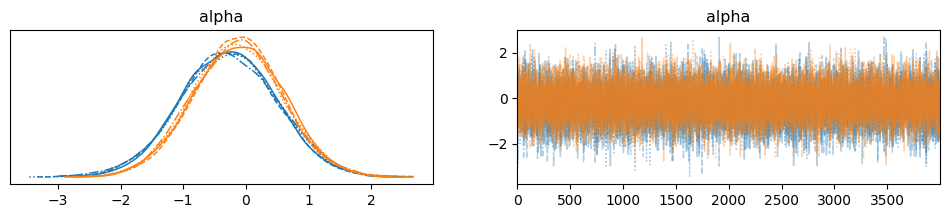

In [9]:
az.plot_trace(boxh1_trace, var_names=["alpha"])

In [10]:
alpha_summary = az.summary(boxh1_trace, var_names=["alpha"])
alpha_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.282,0.778,-1.676,1.236,0.006,0.006,15900.0,11815.0,1.0
alpha[1],-0.136,0.720,-1.508,1.200,0.005,0.006,17454.0,11820.0,1.0


## H2. A game's difficulty configuration and trial have an effect on a player's perception of Mastery



In [11]:
mas_levels

Index([1, 2, 3, 4, 5, 6], dtype='int64')

In [12]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats}) as mboxh2:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=mas_codes)
    boxh2_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    # boxh2_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    

Sampling: [alpha, cutpoints, delta_0, delta_1, sigma, y]


<Axes: xlabel='y'>

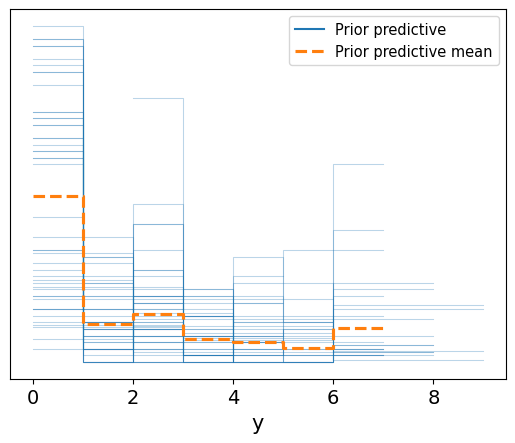

In [13]:
az.plot_ppc(
    boxh2_trace,
    data_pairs={"S": "S"},
    kind="kde",
    alpha=0.3,
    group="prior"
)

In [14]:
with mboxh2:
    boxh2_trace.extend(pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro"))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/projects/ITU/2025-spring/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

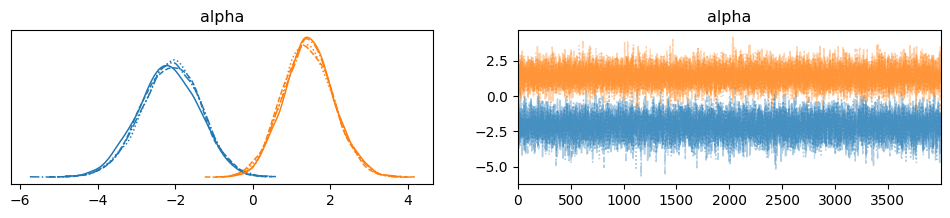

In [15]:
az.plot_trace(boxh2_trace, var_names=["alpha"])

In [16]:
az.summary(boxh2_trace, var_names="alpha")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-2.138,0.774,-3.588,-0.693,0.008,0.005,10544.0,11189.0,1.0
alpha[1],1.422,0.658,0.244,2.723,0.005,0.004,16752.0,11956.0,1.0


In [17]:
with mboxh2:
    pm.sample_posterior_predictive(boxh2_trace, extend_inferencedata=True, random_seed=rng)

Sampling: [y]


Output()

<Axes: xlabel='y'>

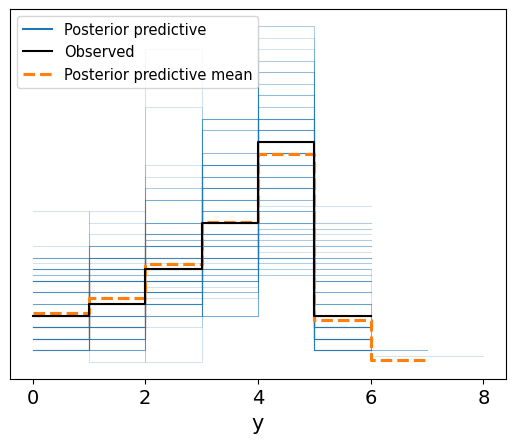

In [18]:
az.plot_ppc(
    boxh2_trace,
    num_pp_samples=100
)

## H3. A game's difficulty configuration and trial has an effect on its perception of Challenge

In [19]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats}) as mboxh3:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=ch_codes)
    boxh3_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    # boxh2_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")

Sampling: [alpha, cutpoints, delta_0, delta_1, sigma, y]


<Axes: xlabel='y'>

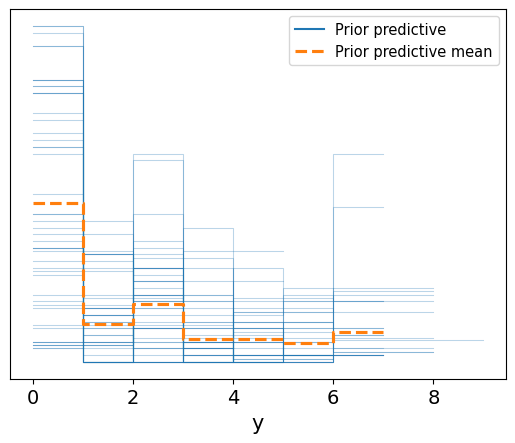

In [20]:
az.plot_ppc(
    boxh3_trace,
    data_pairs={"S": "S"},
    kind="kde",
    alpha=0.3,
    group="prior"
)

In [21]:
with mboxh3:
    boxh3_trace.extend(pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro"))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/projects/ITU/2025-spring/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

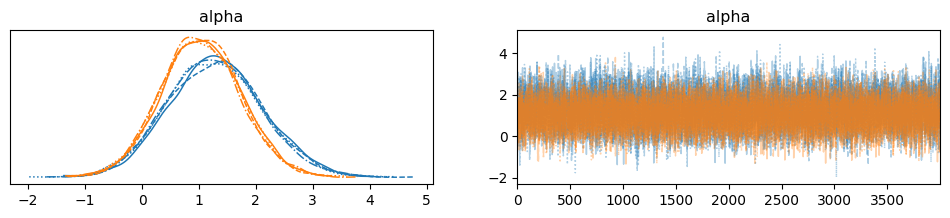

In [22]:
az.plot_trace(boxh3_trace, var_names=["alpha"])

In [23]:
az.summary(boxh3_trace, var_names="alpha")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.279,0.824,-0.301,2.788,0.008,0.006,10423.0,9930.0,1.0
alpha[1],1.029,0.697,-0.250,2.343,0.006,0.005,12980.0,12143.0,1.0


## H4. A game's difficulty configuration and trial have an effect on their Performance



In [24]:
with pm.Model(coords={"trials": trial_cats, "difficulties": diff_cats}) as mboxh4:
    T = pm.Data("trial", trial_id)
    D = pm.Data("difficulty", diff_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    phi = pm.HalfNormal('phi', 5)
    
    lambd = pm.Deterministic("lambd", pm.math.exp(alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T]))
    
    S = pm.NegativeBinomial("S", mu=lambd, alpha=phi, observed=scores)

    boxh4_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    
    

Sampling: [S, alpha, delta_0, delta_1, phi]


In [25]:
with mboxh4:
    boxh4_trace.extend(pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro"))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/projects/ITU/2025-spring/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

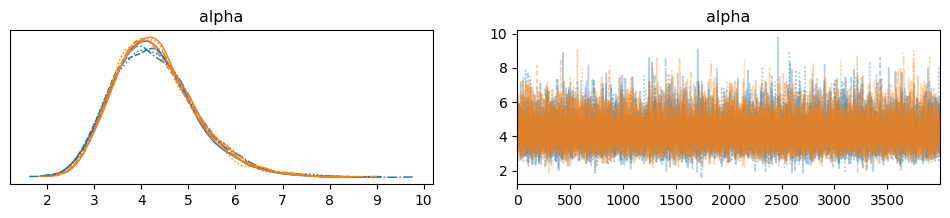

In [26]:
az.plot_trace(boxh4_trace,var_names=["alpha"])

In [27]:
az.summary(boxh4_trace,var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],4.289,0.916,2.681,6.022,0.008,0.006,14892.0,10450.0,1.0
alpha[1],4.304,0.886,2.731,5.951,0.008,0.006,15521.0,9894.0,1.0


## H5: The effects of the trial and difficulty configuration on its perception of mastery are mediated by the score

In [29]:
scores_st = (scores - scores.mean())/scores.std()

In [30]:
with pm.Model(coords={"trials": trial_cats, "difficulties": diff_cats}) as m_boxh5:
    T = pm.Data("trial", trial_id)
    D = pm.Data("difficulty", diff_id)
    S = pm.Data("S", scores_st)
    MAS = pm.Data("MAS", mas_codes)
    
    alpha = pm.Normal("alpha", 0, 2, shape=2)
    beta = pm.Normal("beta",0, 2)
    
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T] + beta*S)
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=MAS)
    
    
    
    boxh5_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.95, random_seed=rng, nuts_sampler="numpyro")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/projects/ITU/2025-spring/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

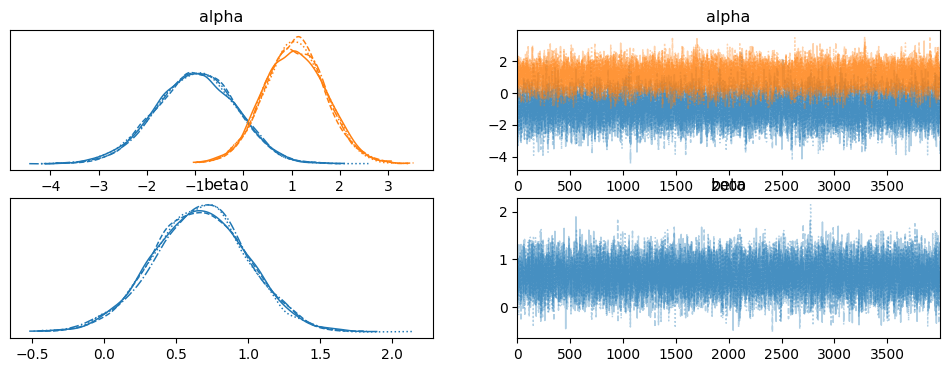

In [31]:
az.plot_trace(boxh5_trace, var_names=["alpha", "beta"])

In [32]:
az.summary(boxh5_trace, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.993,0.836,-2.593,0.509,0.009,0.006,8867.0,9889.0,1.0
alpha[1],1.071,0.639,-0.096,2.308,0.006,0.004,13369.0,11699.0,1.0
beta,0.667,0.327,0.081,1.319,0.003,0.002,11580.0,11552.0,1.0


# Turmoil

In [33]:
pxi_df_turm = pxi_df[pxi_df["game_name"] == "Turmoil"].drop(columns="game_name")
final_frames = logs_df[logs_df["game_name"]=="Turmoil-v5"].groupby(["participant_id", "trial"])["frame"].idxmax()
grouped_turm_df = logs_df.iloc[list(final_frames.values)]

turm_score = grouped_turm_df[["participant_id", "trial", "ram_9", "ram_10", "ram_57"]]
turm_final = pd.merge(pxi_df_turm, turm_score, left_on=("participant_id", "trial"), right_on=("participant_id", "trial")).dropna()
turm_final.shape


(54, 20)

In [34]:
def bcd16_to_decimal(hi_byte: int, lo_byte: int) -> int:
    """
    Convert a 16-bit BCD score (two bytes) to a regular integer.
    
    Parameters:
        hi_byte (int): High BCD byte (tens and thousands).
        lo_byte (int): Low BCD byte (ones and hundreds).
    
    Returns:
        int: The decoded decimal score.
    """
    # Extract nibbles from high byte
    hi_tens = (hi_byte >> 4) & 0x0F
    hi_ones = hi_byte & 0x0F
    
    # Extract nibbles from low byte
    lo_tens = (lo_byte >> 4) & 0x0F
    lo_ones = lo_byte & 0x0F
    
    # Compute decimal value
    return hi_tens * 1000 + hi_ones * 100 + lo_tens * 10 + lo_ones

turm_final["score"] = turm_final.apply(lambda x: bcd16_to_decimal(x['ram_10'], x['ram_9']), 
                        axis=1)
turm_final["deaths"] = 4 - turm_final["ram_57"]

In [35]:
def score_death_ratio(score, deaths):
    if deaths == 0:
        return score
    return score/deaths

turm_final["score_death_ratio"] = turm_final.apply(lambda x: score_death_ratio(x['score'], x['deaths']), 
                        axis=1)

In [36]:
pxi_id_to_number = {
    "strongly disagree": 0,
    "disagree": 1,
    "slightly disagree":2,
    "neutral": 3,
    "slightly agree": 4,
    "agree": 5,
    "strongly agree": 6
}

diff_id,   diff_cats = pd.factorize(turm_final["mode"], sort=True)
trial_id, trial_cats = pd.factorize(turm_final["trial"], sort=True)
ch_codes, ch_levels   = pd.factorize(turm_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
mas_codes, mas_levels   = pd.factorize(turm_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
imm_codes, imm_levels   = pd.factorize(turm_final["pxi_IMM"].str.lower().replace(pxi_id_to_number), sort=True)
scores                = turm_final["score_death_ratio"].values

/tmp/ipykernel_55441/674483900.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ch_codes, ch_levels   = pd.factorize(turm_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_55441/674483900.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mas_codes, mas_levels   = pd.factorize(turm_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_55441/674483900.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To reta

In [37]:
imm_levels

Index([3, 4, 5, 6], dtype='int64')

## H1: A game's difficulty configuration and trial has an effect on a player's perception of Immersion

In [40]:
with pm.Model(coords={"difficulties": diff_cats, "trials":trial_cats}) as mturmh1:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,3,3), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=imm_codes)
    
    
    turmh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True},target_accept=0.95, random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/projects/ITU/2025-spring/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

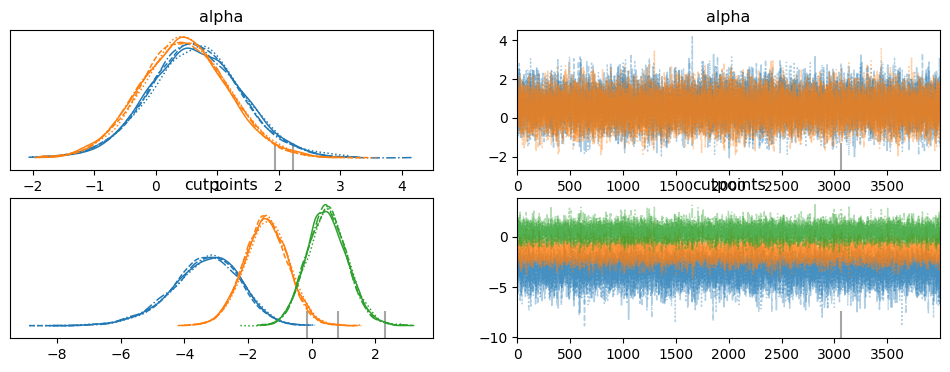

In [41]:
az.plot_trace(turmh1_trace, var_names=["alpha", "cutpoints"])

In [42]:
alpha_summary = az.summary(turmh1_trace, var_names="alpha")
alpha_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.640,0.755,-0.794,2.069,0.007,0.005,12907.0,10544.0,1.0
alpha[1],0.463,0.706,-0.867,1.788,0.007,0.005,11441.0,10427.0,1.0


## H2: A game's difficulty configuration and trial have an effect on their perception of mastery

In [43]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats}) as mturmh2:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=mas_codes)
    # turmh2_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    turmh2_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/projects/ITU/2025-spring/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

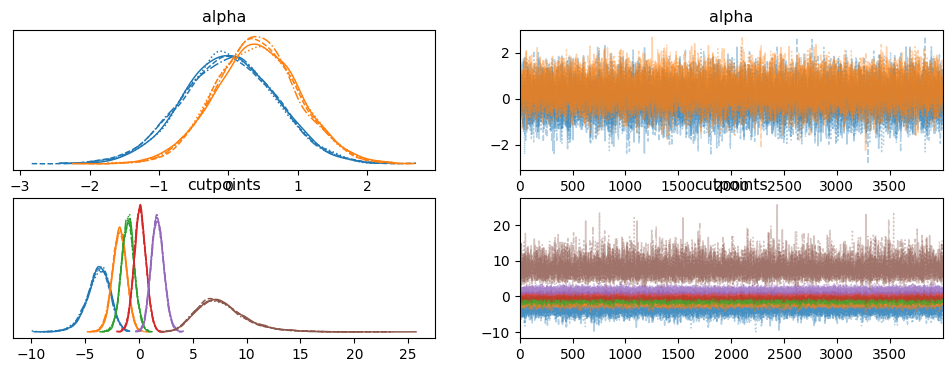

In [44]:
az.plot_trace(turmh2_trace,var_names=["alpha", "cutpoints"])

In [45]:
az.summary(turmh2_trace,var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.013,0.677,-1.217,1.318,0.006,0.005,15077.0,12038.0,1.0
alpha[1],0.406,0.601,-0.714,1.551,0.005,0.004,16670.0,12066.0,1.0


## H3 a game's Difficulty configuration and trial have an effect on the perception of challenge

In [46]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats}) as mturmh3:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=ch_codes)
    # turmh2_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    turmh3_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/projects/ITU/2025-spring/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

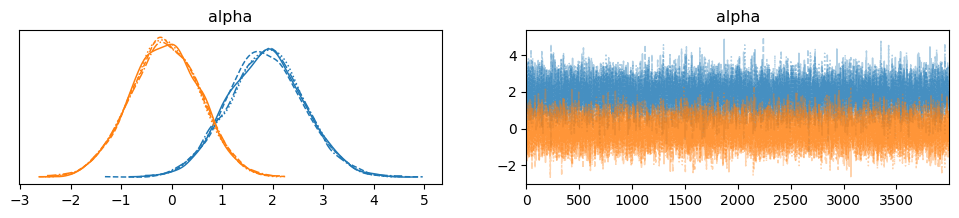

In [47]:
az.plot_trace(turmh3_trace, var_names="alpha")

In [48]:
az.summary(turmh3_trace, var_names="alpha")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.862,0.756,0.430,3.275,0.007,0.005,12237.0,11490.0,1.0
alpha[1],-0.129,0.690,-1.447,1.150,0.006,0.005,11543.0,11519.0,1.0


## H4. A game's difficulty configuration and trial have an effect on their Performance

In [50]:
with pm.Model(coords={"trials": trial_cats, "difficulties": diff_cats}) as mturmh4:
    T = pm.Data("trial", trial_id)
    D = pm.Data("difficulty", diff_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    phi = pm.HalfNormal('phi', 5)
    
    lambd = pm.Deterministic("lambd", pm.math.exp(alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T]))
    
    S = pm.NegativeBinomial("S", mu=lambd, alpha=phi, observed=scores)

    turmh4_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/projects/ITU/2025-spring/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

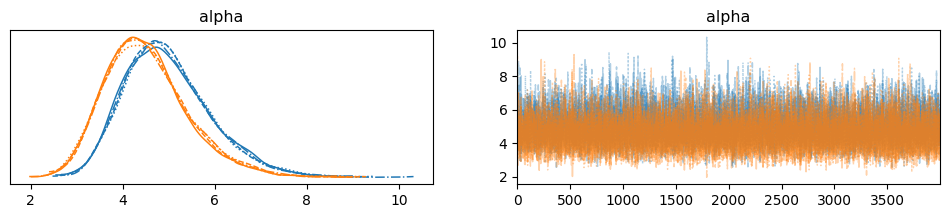

In [51]:
az.plot_trace(turmh4_trace, var_names="alpha")

## H5: The effects of the trial and difficulty configuration on its perception of challenge are mediated by the score

In [52]:
scores_st = (scores - scores.mean())/scores.std()

In [53]:
with pm.Model(coords={"trials": trial_cats, "difficulties": diff_cats}) as m_turmh5:
    T = pm.Data("trial", trial_id)
    D = pm.Data("difficulty", diff_id)
    S = pm.Data("S", scores_st)
    CH = pm.Data("challenge", ch_codes)
    
    alpha = pm.Normal("alpha", 0, 2, shape=2)
    beta = pm.Normal("beta",0, 2)
    
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T] + beta*S)
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=CH)
    
    
    
    turmh5_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.95, random_seed=rng, nuts_sampler="numpyro")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/projects/ITU/2025-spring/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

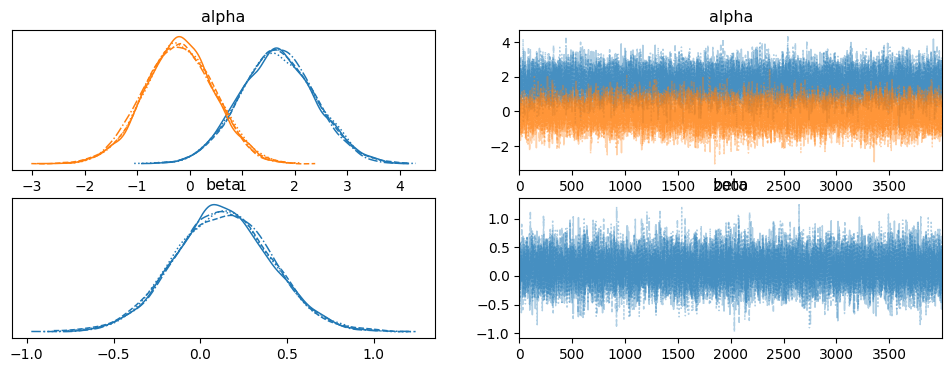

In [54]:
az.plot_trace(turmh5_trace, var_names=["alpha", "beta"])

In [56]:
az.summary(turmh5_trace, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.679,0.717,0.378,3.063,0.006,0.004,14484.0,10931.0,1.0
alpha[1],-0.193,0.666,-1.429,1.074,0.006,0.005,13917.0,12109.0,1.0
beta,0.130,0.279,-0.395,0.658,0.002,0.002,18693.0,11620.0,1.0


# Word Zapper

In [209]:
pxi_df_word = pxi_df[pxi_df["game_name"] == "WordZapper"].drop(columns="game_name")
final_frames = logs_df[logs_df["game_name"]=="WordZapper-v5"].groupby(["participant_id", "trial"])["frame"].idxmax()
grouped_word_df = logs_df.iloc[list(final_frames.values)]

word_score = grouped_turm_df[["participant_id", "trial", "ram_98"]]
word_final = pd.merge(pxi_df_word, word_score, left_on=("participant_id", "trial"), right_on=("participant_id", "trial"))


In [210]:
diff_id,   diff_cats = pd.factorize(word_final["difficulty"].replace(diff_order), sort=True)
ch_codes, ch_levels   = pd.factorize(word_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
mas_codes, mas_levels   = pd.factorize(word_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
imm_codes, imm_levels   = pd.factorize(word_final["pxi_IMM"].str.lower().replace(pxi_id_to_number), sort=True)
scores                = word_final["ram_98"].values

/tmp/ipykernel_64458/3899615534.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ch_codes, ch_levels   = pd.factorize(word_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_64458/3899615534.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mas_codes, mas_levels   = pd.factorize(word_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_64458/3899615534.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To reta

In [213]:
mas_levels

Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

## H1: A game's difficulty configuration or current trial have an effect on on a player's perception of challenge

In [71]:
y_ch.unique()

array([0, 4, 2, 1, 5, 6, 3])

In [72]:
with pm.Model(coords={"difficulties": unique_diff, "trials": unique_trial}) as m_wordh1:
    current_difficulty = pm.Data("difficulty", diff_id)
    current_trial = pm.Data("trial", trial_id)
    
    alpha = pm.Normal("alpha", 0, 0.5, dims="difficulties")
    beta = pm.Normal("beta", 0, 0.5, dims="trials")
    sigma = pm.Exponential("sigma", 0.25)
    
    eta = pm.Deterministic("eta", alpha[current_difficulty] + beta[current_trial]) # 
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=y_ch.values)
    
    wordh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    
    

Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

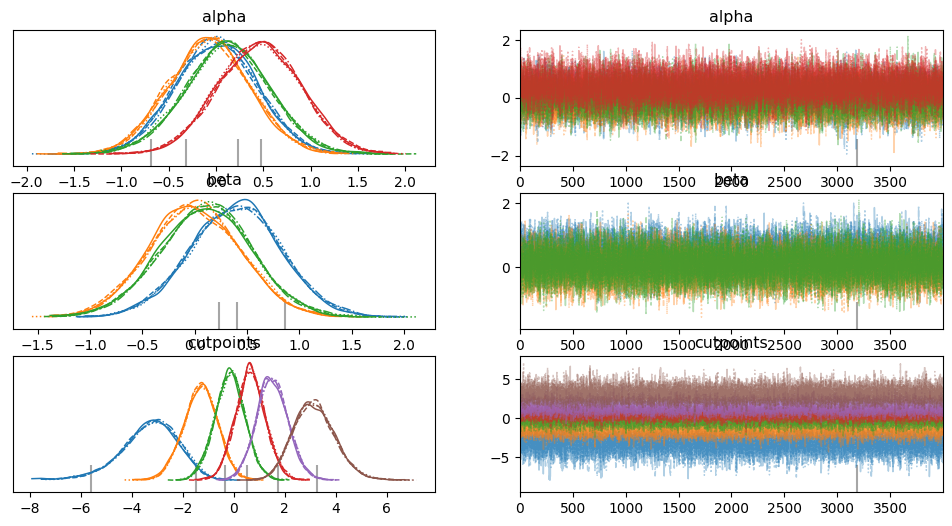

In [ ]:
az.plot_trace(wordh1_trace, var_names=["alpha", "beta", "cutpoints"])

In [ ]:
alpha_summary = az.summary(wordh1_trace, var_names="alpha")
alpha_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[2.0],0.004,0.431,-0.793,0.818,0.003,0.004,20375.0,11137.0,1.0
alpha[1.0],-0.071,0.427,-0.859,0.740,0.003,0.004,19663.0,11672.0,1.0
alpha[0.0],0.123,0.449,-0.718,0.975,0.003,0.004,17110.0,9709.0,1.0
alpha[3.0],0.457,0.435,-0.362,1.257,0.003,0.003,17425.0,10232.0,1.0


In [ ]:
beta_summary = az.summary(wordh1_trace, var_names="beta")
beta_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[1.0],0.392,0.433,-0.450,1.182,0.003,0.003,19044.0,11295.0,1.0
beta[2.0],0.000,0.433,-0.827,0.797,0.003,0.003,16885.0,11617.0,1.0
beta[3.0],0.108,0.438,-0.723,0.928,0.003,0.004,19307.0,10638.0,1.0


#### interaction model

In [ ]:
with pm.Model(coords={"trials": unique_trial, "difficulties": unique_diff}) as m_wordh2_int:
    current_trial = pm.Data("trial", trial_id)
    current_difficulty = pm.Data("difficulty", diff_id)
    
    beta = pm.Normal("beta", 0, 0.5, dims="trials")
    alpha = pm.Normal("alpha", 0, 0.5, dims="difficulties")
    gamma = pm.Normal("gamma", 0, 0.5, dims=("difficulties", "trials"))
    sigma = pm.Exponential("sigma", 0.25)
    
    eta = pm.Deterministic("eta", alpha[current_difficulty] + beta[current_trial] + gamma[current_difficulty, current_trial])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedProbit("y", eta=eta, cutpoints=cutpoints, observed=y_ch.values)
    
    wordh2_int_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, gamma, sigma, cutpoints]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

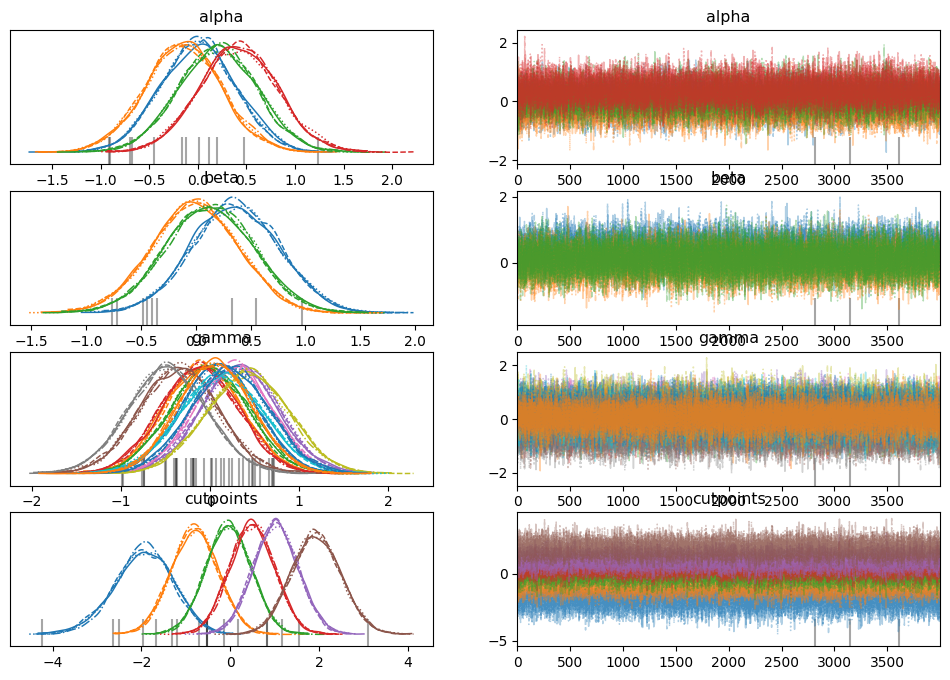

In [ ]:
az.plot_trace(wordh2_int_trace, var_names=["alpha", "beta", "gamma", "cutpoints"])

In [ ]:
alpha_summary_h3 = az.summary(wordh2_int_trace, var_names="alpha")
alpha_summary_h3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[2.0],0.003,0.389,-0.719,0.736,0.003,0.003,15874.0,12935.0,1.0
alpha[1.0],-0.152,0.395,-0.910,0.589,0.003,0.003,16477.0,11778.0,1.0
alpha[0.0],0.203,0.405,-0.556,0.967,0.003,0.003,18118.0,12445.0,1.0
alpha[3.0],0.417,0.402,-0.349,1.168,0.003,0.002,17548.0,12229.0,1.0


In [ ]:
beta_summary_h3 = az.summary(wordh2_int_trace, var_names="beta")
beta_summary_h3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[1.0],0.364,0.398,-0.375,1.122,0.003,0.003,16087.0,12605.0,1.0
beta[2.0],-0.006,0.394,-0.761,0.722,0.003,0.003,15362.0,12611.0,1.0
beta[3.0],0.124,0.402,-0.625,0.888,0.003,0.003,14668.0,11937.0,1.0


In [ ]:
gamma_summary_h3 = az.summary(wordh2_int_trace, var_names="gamma")
gamma_summary_h3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"gamma[2.0, 1.0]",0.093,0.427,-0.696,0.899,0.003,0.003,20948.0,12210.0,1.0
"gamma[2.0, 2.0]",-0.080,0.428,-0.876,0.720,0.003,0.004,21903.0,11859.0,1.0
"gamma[2.0, 3.0]",-0.015,0.440,-0.823,0.820,0.003,0.004,23769.0,11539.0,1.0
"gamma[1.0, 1.0]",-0.121,0.433,-0.929,0.691,0.003,0.003,22254.0,11210.0,1.0
"gamma[1.0, 2.0]",0.333,0.440,-0.520,1.142,0.003,0.003,21993.0,11442.0,1.0
"gamma[1.0, 3.0]",-0.355,0.441,-1.171,0.497,0.003,0.003,19888.0,11613.0,1.0
"gamma[0.0, 1.0]",0.255,0.431,-0.565,1.057,0.003,0.003,23699.0,12533.0,1.0
"gamma[0.0, 2.0]",-0.479,0.442,-1.297,0.364,0.003,0.003,22189.0,12049.0,1.0
"gamma[0.0, 3.0]",0.420,0.460,-0.446,1.270,0.003,0.003,21970.0,12055.0,1.0
"gamma[3.0, 1.0]",0.134,0.473,-0.725,1.055,0.003,0.004,23581.0,11318.0,1.0
